In [6]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING device :",device)
print(torch.cuda.get_device_name(0))

USING device : cuda
NVIDIA A100-SXM4-80GB


# Data Processing

In [7]:
import numpy as np
import os
# from sklearn.preprocessing import LabelEncoder
import cv2

In [8]:
data_path = r"../datasets/office31"
num_domains = 3
num_classes = 31
all_domains = ["amazon", "dslr", "webcam"]
all_classes = ["back_pack", "bike", "bike_helmet", "bookcase", "bottle", "calculator", "desk_chair", "desk_lamp", \
               "desktop_computer", "file_cabinet", "headphones", "keyboard", "laptop_computer", "letter_tray", "mobile_phone", \
                "monitor", "mouse", "mug", "paper_notebook", "pen", "phone", "printer", "projector", "punchers", \
                "ring_binder", "ruler", "scissors", "speaker", "stapler", "tape_dispenser", "trash_can"]

train_dom_idx = [0,1]
eval_dom_idx = [2]
train_class_idx = list(range(29))
eval_class_idx = [29,30]
train_domains = all_domains[:2]
eval_domains = all_domains[2:]
train_classes = all_classes[:29]
eval_classes = all_classes[29:]

len(train_classes)

29

In [9]:
def image_reader(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

In [10]:
dTrain_images = []
cTrain_images = {dom:[] for dom in train_domains}
dTest_images = []
cTest_images = {dom:[] for dom in train_domains}
dTrain_label = []
cTrain_label = {dom:[] for dom in train_domains}
dTest_label = []
cTest_label = {dom:[] for dom in train_domains}

for d in range(len(train_domains)):
    domain = train_domains[d]
    for c in range(len(train_classes)):
        clas = train_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            file_path = os.path.join(directory_path, file_name)
            if np.random.uniform(0.0, 1.0) < 0.8:
                dTrain_images.append(image_reader(file_path))
                dTrain_label.append(d)
                cTrain_images[domain].append(image_reader(file_path))
                cTrain_label[domain].append(c)
            else:
                dTest_images.append(image_reader(file_path))
                dTest_label.append(d)
                cTest_images[domain].append(image_reader(file_path))
                cTest_label[domain].append(c)

dLabel_mapping = {i:train_domains[i] for i in range(len(train_domains))}
cLabel_mapping = {i:train_classes[i] for i in range(len(train_classes))}

In [11]:
def numpi_shuffler(images, labels):
    images_np = np.array(images)
    encoded_labels_np = np.array(labels)

    # Create a random permutation of indices and shuffle arrays
    indices = np.random.permutation(len(images_np))
    shuffled_images = images_np[indices]
    shuffled_labels = encoded_labels_np[indices]

    return shuffled_images, shuffled_labels

In [12]:
dTrain_images, dTrain_label = numpi_shuffler(dTrain_images, dTrain_label)
dTest_images, dTest_label = numpi_shuffler(dTest_images, dTest_label)
for dom in train_domains:
    cTrain_images[dom], cTrain_label[dom] = numpi_shuffler(cTrain_images[dom], cTrain_label[dom])
    cTest_images[dom], cTest_label[dom] = numpi_shuffler(cTest_images[dom], cTest_label[dom])

# Model Setup

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image

In [14]:
# ---------------- Custom Dataset with Data Augmentation ----------------
# Assuming training_images and testing_images are NumPy arrays with shape (N, 128, 128, 3)
# and training_labels and testing_labels are NumPy arrays with integer labels.
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: NumPy array of shape (N, 128, 128, 3)
        labels: NumPy array of shape (N,)
        transform: torchvision transforms to be applied on each image
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert the NumPy image (H, W, C) to a PIL Image for transforms
        image = Image.fromarray((image * 255).astype(np.uint8))  # if images are in [0,1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (64, 64, 64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # (128, 16, 16)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        # Flatten the feature maps: alternative to x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


In [16]:
# ---------------- Define Transforms ----------------
# Training transform with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Rotate by up to 10 degrees
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop and resize back to 128x128
    transforms.ToTensor(),
    # If you used normalization during training, add it here.
    # e.g., transforms.Normalize(mean=[...], std=[...])
])

# Testing transform: only resize and convert to tensor
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [17]:
# Create custom datasets and Dataloaders
dTrain_dataset = CustomDataset(dTrain_images, dTrain_label, transform=train_transform)
dTest_dataset = CustomDataset(dTest_images, dTest_label, transform=test_transform)
dTrain_loader = DataLoader(dTrain_dataset, batch_size=32, shuffle=True)
dTest_loader  = DataLoader(dTest_dataset, batch_size=32, shuffle=False)

cTrain_datasets = {dom:CustomDataset(cTrain_images[dom], cTrain_label[dom], transform=train_transform) for dom in train_domains}
cTest_datasets = {dom:CustomDataset(cTest_images[dom], cTest_label[dom], transform=train_transform) for dom in train_domains}
cTrain_loaders = {dom:DataLoader(cTrain_datasets[dom], batch_size=32, shuffle=True) for dom in train_domains}
cTest_loaders  = {dom:DataLoader(cTest_datasets[dom], batch_size=32, shuffle=False) for dom in train_domains}

domain_model = SimpleCNN(num_classes=len(train_domains)).to(device)
class_models = {dom:SimpleCNN(num_classes=len(train_classes)).to(device) for dom in train_domains}

In [18]:
num_epochs = 20
def Trainer(num_epochs, learning_rate, weight_d, model, train_loader, train_dataset):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_d)
    # Optionally, add a learning rate scheduler:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images=images.to(device)
            #labels = torch.tensor(labels)
            labels=labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # Update scheduler if using one
        scheduler.step(epoch_loss)

In [19]:
# print("Domain Classifier")
# Trainer(num_epochs, 0.001, 1e-5, domain_model, dTrain_loader, dTrain_dataset)

for dom in train_domains:
    print(dom+" Classifier")
    Trainer(50, 0.0001, 1e-5, class_models[dom], cTrain_loaders[dom], cTrain_datasets[dom])

amazon Classifier
Epoch [1/50], Loss: 3.3605
Epoch [2/50], Loss: 3.2357
Epoch [3/50], Loss: 3.0911
Epoch [4/50], Loss: 3.0115
Epoch [5/50], Loss: 2.9216
Epoch [6/50], Loss: 2.8534
Epoch [7/50], Loss: 2.7990
Epoch [8/50], Loss: 2.7261
Epoch [9/50], Loss: 2.6629
Epoch [10/50], Loss: 2.6157
Epoch [11/50], Loss: 2.5822
Epoch [12/50], Loss: 2.5280
Epoch [13/50], Loss: 2.4896
Epoch [14/50], Loss: 2.4447
Epoch [15/50], Loss: 2.3892
Epoch [16/50], Loss: 2.3508
Epoch [17/50], Loss: 2.3261
Epoch [18/50], Loss: 2.3065
Epoch [19/50], Loss: 2.2535
Epoch [20/50], Loss: 2.1914
Epoch [21/50], Loss: 2.1828
Epoch [22/50], Loss: 2.1114
Epoch [23/50], Loss: 2.1330
Epoch [24/50], Loss: 2.1281
Epoch [25/50], Loss: 2.0701
Epoch [26/50], Loss: 2.0365
Epoch [27/50], Loss: 1.9917
Epoch [28/50], Loss: 2.0152
Epoch [29/50], Loss: 1.9566
Epoch [30/50], Loss: 1.9564
Epoch [31/50], Loss: 1.9228
Epoch [32/50], Loss: 1.9503
Epoch [33/50], Loss: 1.8979
Epoch [34/50], Loss: 1.9058
Epoch [35/50], Loss: 1.8558
Epoch [36/5

In [20]:
print("Domain Classifier")
Trainer(num_epochs, 0.001, 1e-5, domain_model, dTrain_loader, dTrain_dataset)

Domain Classifier
Epoch [1/20], Loss: 0.1055
Epoch [2/20], Loss: 0.0566
Epoch [3/20], Loss: 0.0409
Epoch [4/20], Loss: 0.0351
Epoch [5/20], Loss: 0.0198
Epoch [6/20], Loss: 0.0318
Epoch [7/20], Loss: 0.0241
Epoch [8/20], Loss: 0.0355
Epoch [9/20], Loss: 0.0141
Epoch [10/20], Loss: 0.0151
Epoch [11/20], Loss: 0.0228
Epoch [12/20], Loss: 0.0159
Epoch [13/20], Loss: 0.0226
Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
Epoch [14/20], Loss: 0.0184
Epoch [15/20], Loss: 0.0090
Epoch [16/20], Loss: 0.0061
Epoch [17/20], Loss: 0.0053
Epoch [18/20], Loss: 0.0078
Epoch [19/20], Loss: 0.0083
Epoch [20/20], Loss: 0.0197


***MODEL EVALUATION**

1. CLASSIFICATION REPORT USING SEG_TEST
2. CONFUSION MATRIX

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [30]:
def Tester(model, test_loader, class_names):
    model.eval()
    all_preds=[]
    all_labels=[]
    all_certs=[]

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)
            outputs= model(images)
            probs = F.softmax(outputs, dim=1)
            certs,preds = torch.max(probs,1)
            all_certs.extend(certs.cpu().numpy())
            #_,preds=torch.max(outputs,1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    print("Confusion Matrix:\n",conf_matrix)

    # print(outputs)
    # print(probs)
    # print(preds)

    # plt.figure(figsize=(8,6))
    # sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=class_names,yticklabels=class_names)
    # plt.xlabel("predicted class")
    # plt.ylabel("actual class")
    # plt.title("Confusion Matrix")

    plt.figure(figsize=(8,6))
    plt.hist(all_certs, 10)
    plt.show()

classification report:
               precision    recall  f1-score   support

      amazon       1.00      0.99      1.00       534
        dslr       0.97      1.00      0.98       112

    accuracy                           0.99       646
   macro avg       0.98      1.00      0.99       646
weighted avg       0.99      0.99      0.99       646

Confusion Matrix:
 [[530   4]
 [  0 112]]


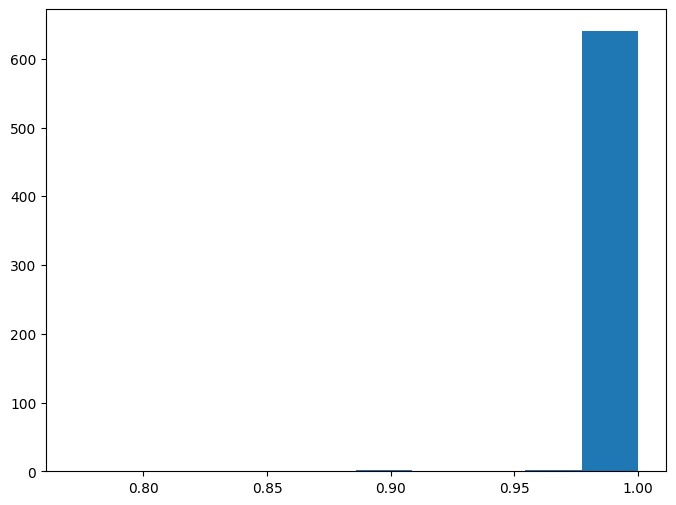

In [31]:
Tester(domain_model, dTest_loader, train_domains)

classification report:
                   precision    recall  f1-score   support

       back_pack       0.65      0.76      0.70        17
            bike       0.75      1.00      0.86        12
     bike_helmet       0.37      0.50      0.43        20
        bookcase       0.58      0.39      0.47        18
          bottle       0.00      0.00      0.00         4
      calculator       0.36      0.62      0.45         8
      desk_chair       0.71      0.80      0.75        15
       desk_lamp       0.53      0.57      0.55        14
desktop_computer       0.79      0.37      0.50        30
    file_cabinet       0.37      0.50      0.43        20
      headphones       0.62      0.64      0.63        25
        keyboard       0.50      0.58      0.54        26
 laptop_computer       0.61      0.70      0.65        20
     letter_tray       0.44      0.46      0.45        24
    mobile_phone       0.62      0.53      0.57        15
         monitor       0.91      0.78      0.84

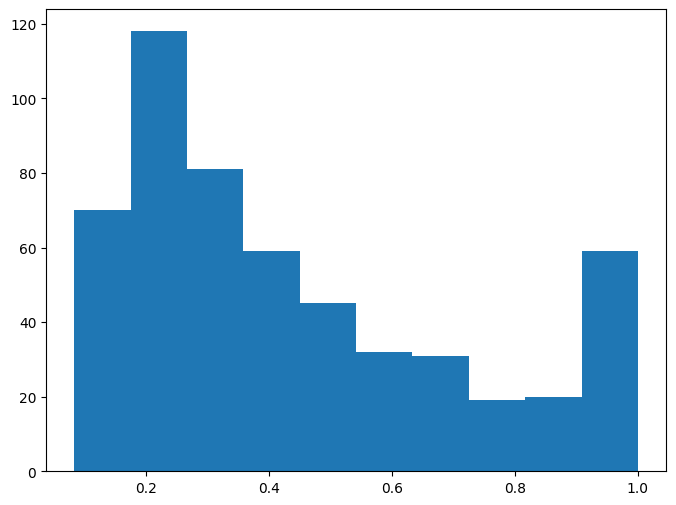

In [32]:
Tester(class_models["amazon"], cTest_loaders["amazon"], train_classes)

In [35]:
len(train_classes)

29

In [34]:
Tester(class_models["dslr"], cTest_loaders["dslr"], train_classes)

ValueError: Number of classes, 28, does not match size of target_names, 29. Try specifying the labels parameter

In [ ]:
pred_path = "../datasets/office31/webcam/bike/frame_0001.jpg"

In [ ]:
# Move model and image tensor to the device (GPU if available)
def Evaluator(model, img_path, labels):
    img = Image.open(img_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize to 128x128
        transforms.ToTensor(),          
    ])

    img_tensor = transform(img).unsqueeze(0)
    model.to(device)
    img_tensor = img_tensor.to(device)

    # Evaluate the model on the image
    model.eval()
    with torch.no_grad():
        #AttributeError: 'CustomDataset' object has no attribute 'size'
        output = model(img_tensor)
        print(type(output), output)
        probs = F.softmax(output, dim=1)
        print(probs)
        _, predicted = torch.max(output)

    predicted_label = predicted.item()
    print(predicted_label, labels[predicted_label])
    return 

In [ ]:
# Move model and image tensor to the device (GPU if available)
def CompleteEvaluator(domain_model, class_models, img_tensor, train_domains, train_classes):
    domain_model.to(device)
    img_tensor = img_tensor.to(device)

    # Evaluate the domain model on the image
    domain_model.eval()
    with torch.no_grad():
        #AttributeError: 'CustomDataset' object has no attribute 'size'
        domain_logits = domain_model(img_tensor)
        print(type(output), output)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()
    print(predicted_label, labels[predicted_label])

In [ ]:
Evaluator(domain_model, pred_path, train_domains)

<class 'torch.Tensor'> tensor([[0.0017, 0.1803]], device='cuda:0')
tensor([[0.4555, 0.5445]], device='cuda:0')
1 dslr


In [37]:
Evaluator(class_models["amazon"], img_tensor, train_classes)

<class 'torch.Tensor'> tensor([[-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
         -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
         -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
         -0.9316, -1.7128, -0.6711, -0.7449, -2.5976]], device='cuda:0')
tensor([[1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
         2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
         4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
         5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
         3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03]],
       device='cuda:0')
23 punchers


In [38]:
Evaluator(class_models["dslr"], img_tensor, train_classes)

<class 'torch.Tensor'> tensor([[ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
         -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
         -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
         -2.3688, -3.3043,  0.4179,  1.2234,  0.3381]], device='cuda:0')
tensor([[4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
         3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
         1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
         3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
         2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03]],
       device='cuda:0')
1 bike


In [2]:
import numpy as np

In [3]:
dom_logits = [0.0017, 0.1803]
dom_probs = [0.4555, 0.5445]

amazon_logits = np.array([-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
         -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
         -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
         -0.9316, -1.7128, -0.6711, -0.7449, -2.5976])
amazon_probs = np.array([1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
         2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
         4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
         5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
         3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03])

dslr_logits = np.array([ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
         -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
         -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
         -2.3688, -3.3043,  0.4179,  1.2234,  0.3381])
dslr_probs = np.array([4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
         3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
         1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
         3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
         2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03])

In [41]:
np.argmax(dslr_logits)

1

In [42]:
np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

1

In [5]:
0.4555*amazon_probs + 0.5445*dslr_probs

array([0.00919341, 0.2304382 , 0.01181907, 0.00641302, 0.01311036,
       0.00112062, 0.21569858, 0.04389722, 0.02687869, 0.10687234,
       0.00910853, 0.00295873, 0.00271485, 0.00508517, 0.00252413,
       0.00099674, 0.0336065 , 0.01996657, 0.02311204, 0.02142014,
       0.0416046 , 0.00297278, 0.00071134, 0.1006196 , 0.01402985,
       0.00641521, 0.02026538, 0.02175439, 0.00469343])

In [50]:
np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

1

In [ ]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
\
# # Path to your prediction folder
pred_folder = "Downloads/archive/seg_pred/seg_pred"

# List all image files in the folder (adjust the extensions as needed)
pred_files = [os.path.join(pred_folder, f) for f in os.listdir(pred_folder)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# # Choose a random image from the folder
random_image_path = random.choice(pred_files)
print("Random image path:", random_image_path)

# Open the image and ensure it's in RGB format
img = Image.open(random_image_path).convert("RGB")

# Define the same transformation used in training
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Converts to tensor and scales pixel values to [0, 1]
    # If you applied normalization during training, add it here.
    # Example: transforms.Normalize(mean=[...], std=[...])
])

# Apply transformation and add batch dimension
img_tensor = transform(img).unsqueeze(0)

# Move model and image tensor to the device (GPU if available)
model.to(device)
img_tensor = img_tensor.to(device)

# Evaluate the model on the image
model.eval()
with torch.no_grad():AttributeError: 'CustomDataset' object has no attribute 'size'
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

predicted_label = predicted.item()

# Define the class names in the same order as during training
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
predicted_class_name = class_names[predicted_label]

print("Predicted label:", predicted_label)
print("Predicted class:", predicted_class_name)


plt.imshow(img)
plt.title(f"Predicted label: {predicted_label} - {predicted_class_name}")
plt.axis('off')
plt.show()

In [ ]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # (128, 16, 16)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01,inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        # Flatten the feature maps: alternative to x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = ImprovedCNN(num_classes=6).to(device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import KFold
import numpy as np



k_folds = 10
num_epochs = 20

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
folds = list(kf.split(train_dataset)) 

# Create a dictionary to record validation losses for each fold across epochs.
fold_val_losses = {i: [] for i in range(k_folds)}


model = ImprovedCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


for epoch in range(num_epochs):
    
    current_fold = epoch % k_folds  
    print(f"\n--- Epoch {epoch+1}/{num_epochs}, Using Fold {current_fold+1} as Validation ---")
    
    train_idx, val_idx = folds[current_fold]
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()           
        outputs = model(images)           
        loss = criterion(outputs, labels) 
        loss.backward()                   
        optimizer.step()                  
        
        running_loss += loss.item() * images.size(0)
        
    # Compute average training loss for this epoch
    train_loss = running_loss / len(train_subset)
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_subset)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step(val_loss)
    
    # Record the validation loss for the current fold
    fold_val_losses[current_fold].append(val_loss)

# After training, compute the average validation loss for each fold.
avg_fold_losses = {fold: np.mean(losses) for fold, losses in fold_val_losses.items()}
print("\nAverage Validation Loss per Fold:")
for fold in sorted(avg_fold_losses.keys()):
    print(f"Fold {fold+1}: {avg_fold_losses[fold]:.4f}")

# Then, compute the overall average validation loss across folds.
overall_avg_val_loss = np.mean(list(avg_fold_losses.values()))
print(f"\nOverall Average Validation Loss across folds: {overall_avg_val_loss:.4f}")

In [ ]:

class_names= ["buildings","forest","glacier","mountain","sea","street"]

model.eval()
all_preds=[]
all_labels=[]

with torch.no_grad():
    for images,labels in test_loader:
        images=images.to(device)
        labels= labels.to(device)
        outputs= model(images)
        _,preds=torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds=np.array(all_preds)
all_labels=np.array(all_labels)

report= classification_report(all_labels,all_preds,target_names=class_names)
print("classification report:\n",report)

        

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix= confusion_matrix(all_labels,all_preds)
print("Confusion Matrix:\n",conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("predicted class")
plt.ylabel("actual class")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import os
import random
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
\
# # Path to your prediction folder
pred_folder = "Downloads/archive/seg_pred/seg_pred"

# List all image files in the folder (adjust the extensions as needed)
pred_files = [os.path.join(pred_folder, f) for f in os.listdir(pred_folder)
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# # Choose a random image from the folder
random_image_path = random.choice(pred_files)
print("Random image path:", random_image_path)

# Open the image and ensure it's in RGB format
img = Image.open(random_image_path).convert("RGB")

# Define the same transformation used in training
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Converts to tensor and scales pixel values to [0, 1]
    # If you applied normalization during training, add it here.
    # Example: transforms.Normalize(mean=[...], std=[...])
])


# Apply transformation and add batch dimension
img_tensor = transform(img).unsqueeze(0)

# Move model and image tensor to the device (GPU if available)
model.to(device)
img_tensor = img_tensor.to(device)

# Evaluate the model on the image
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

predicted_label = predicted.item()

# Define the class names in the same order as during training
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
predicted_class_name = class_names[predicted_label]

print("Predicted label:", predicted_label)
print("Predicted class:", predicted_class_name)


plt.imshow(img)
plt.title(f"Predicted label: {predicted_label} - {predicted_class_name}")
plt.axis('off')
plt.show()